In [ ]:
!pip install semanticscholar python-dotenv requests -q

import json
import os
from semanticscholar import SemanticScholar
from dotenv import load_dotenv


In [39]:

# FIXED: PDF-ONLY SEARCH (Europe PMC + arXiv) — safer & debug-friendly
!pip install requests feedparser -q

import requests
import feedparser
import json
from datetime import datetime
import os
from urllib.parse import quote_plus

def clean(x):
    return x.replace("\n", " ").strip() if isinstance(x, str) else x

# Europe PMC: use params and check status
def search_europe_pmc(query, limit=50):
    print("\n🔍 Searching Europe PMC...")
    base = "https://www.ebi.ac.uk/europepmc/webservices/rest/search"
    params = {
        "query": query,
        "format": "json",
        "pageSize": limit
    }
    try:
        resp = requests.get(base, params=params, timeout=15)
        if resp.status_code != 200:
            print(f"  ❌ Europe PMC HTTP {resp.status_code}: {resp.text[:300]}")
            return []
        data = resp.json()
        results = data.get("resultList", {}).get("result", [])
    except Exception as e:
        print("  ❌ Europe PMC request error:", e)
        return []

    papers = []
    for p in results:
        pdf_url = None
        # fullTextUrlList may be dict or missing
        ft = p.get("fullTextUrlList") or {}
        urls = ft.get("fullTextUrl", []) if isinstance(ft, dict) else []
        # urls could be list of dicts
        for u in urls:
            if not isinstance(u, dict):
                continue
            urlstr = (u.get("url") or "").lower()
            docstyle = (u.get("documentStyle") or "").lower()
            if "pdf" in urlstr or "pdf" in docstyle:
                pdf_url = u.get("url")
                break

        if not pdf_url:
            # some records expose pdfLink directly
            pdf_url = p.get("pdfLink") or None

        if not pdf_url:
            continue  # skip non-PDF records

        papers.append({
            "title": clean(p.get("title", "")),
            "authors": [a.get("fullName", "") for a in p.get("authorList", {}).get("author", [])] if p.get("authorList") else [],
            "year": int(p["pubYear"]) if p.get("pubYear") else None,
            "paperId": p.get("id", ""),
            "abstract": clean(p.get("abstractText", "")),
            "citationCount": p.get("citedByCount", 0),
            "venue": p.get("journalTitle", ""),
            "url": p.get("pubmedUrl", ""),
            "pdf_url": pdf_url,
            "has_pdf": True,
            "source": "Europe PMC"
        })

    print(f"➡ Europe PMC PDF results: {len(papers)}")
    return papers

# arXiv: ensure query encoded, check feedparser result
def search_arxiv(query, limit=50):
    print("\n🔍 Searching arXiv...")
    # encode query for arXiv
    q = quote_plus(query)
    url = f"http://export.arxiv.org/api/query?search_query=all:{q}&start=0&max_results={limit}"
    try:
        feed = feedparser.parse(url)
    except Exception as e:
        print("  ❌ arXiv parse error:", e)
        return []

    entries = getattr(feed, "entries", None)
    if not entries:
        # helpful debug: show feed.status or raw text length
        status = getattr(feed, "status", "N/A")
        print(f"  ⚠ arXiv returned no entries (status={status}). Try a different query.")
        return []

    papers = []
    for entry in entries:
        # some entries may be missing fields — guard them
        title = clean(getattr(entry, "title", ""))
        authors = [a.name for a in getattr(entry, "authors", [])] if getattr(entry, "authors", None) else []
        published = getattr(entry, "published", "")
        year = None
        if published and len(published) >= 4:
            try:
                year = int(published[:4])
            except:
                year = None
        pdf_url = getattr(entry, "id", "").replace("abs", "pdf") + ".pdf"
        papers.append({
            "title": title,
            "authors": authors,
            "year": year,
            "paperId": getattr(entry, "id", ""),
            "abstract": clean(getattr(entry, "summary", "")),
            "citationCount": 0,
            "venue": "arXiv",
            "url": getattr(entry, "link", ""),
            "pdf_url": pdf_url,
            "has_pdf": True,
            "source": "arXiv"
        })

    print(f"➡ arXiv PDF results: {len(papers)}")
    return papers

def search_papers(query, limit=30):
    if not query:
        print("Please provide a non-empty query.")
        return []
    print(f"\n🔎 Searching for: {query}")
    pmc = search_europe_pmc(query, limit=limit)
    arx = search_arxiv(query, limit=limit)
    all_papers = pmc + arx
    print(f"\n📊 TOTAL PDF papers found: {len(all_papers)}")
    if len(all_papers) == 0:
        print("No PDF papers found. Try a broader query (e.g., 'parkinson gait' or 'freezing of gait').")
    return all_papers

def display_results(papers, limit=10):
    print("\n=========== PDF AVAILABLE PAPERS ===========\n")
    for i, p in enumerate(papers[:limit], 1):
        print(f"{i}. {p.get('title')}")
        print(f"   Authors: {', '.join(p.get('authors', [])[:4])}")
        print(f"   Year: {p.get('year')}  | Source: {p.get('source')}")
        print(f"   PDF: {p.get('pdf_url')}\n")

def save_search_results(papers, topic):
    os.makedirs("data/search_results", exist_ok=True)
    safe_topic = "".join(c for c in topic if c.isalnum() or c == " ").replace(" ", "_")
    filename = f"paper_search_results_{safe_topic}.json"
    path = f"data/search_results/{filename}"
    with open(path, "w", encoding="utf-8") as f:
        json.dump({
            "topic": topic,
            "timestamp": datetime.now().isoformat(),
            "papers": papers
        }, f, indent=4)
    print(f"\n💾 Saved results → {path}")
    return path

# Quick test runner
if __name__ == "__main__":
    q = input("Enter research topic: ").strip()
    papers = search_papers(q, limit=30)
    display_results(papers)
    if papers:
        save_search_results(papers, q)


Enter research topic: parkinson

🔎 Searching for: parkinson

🔍 Searching Europe PMC...
➡ Europe PMC PDF results: 0

🔍 Searching arXiv...
➡ arXiv PDF results: 30

📊 TOTAL PDF papers found: 30

=========== PDF AVAILABLE PAPERS ===========

1. Deep 1D-Convnet for accurate Parkinson disease detection and severity prediction from gait
   Authors: Imanne El Maachi, Guillaume-Alexandre Bilodeau, Wassim Bouachir
   Year: 2019  | Source: arXiv
   PDF: http://arxiv.org/pdf/1910.11509v4.pdf

2. A Three-groups Non-local Model for Combining Heterogeneous Data Sources to Identify Genes Associated with Parkinson's Disease
   Authors: Troy P. Wixson, Benjamin A. Shaby, Daisy L. Philtron, International Parkinson Disease Genomics Consortium
   Year: 2024  | Source: arXiv
   PDF: http://arxiv.org/pdf/2406.05262v1.pdf

3. Optimizing baryon acoustic oscillation surveys II: curvature, redshifts, and external datasets
   Authors: David Parkinson, Martin Kunz, Andrew R. Liddle, Bruce A. Bassett
   Year: 2009 

In [37]:
# ============================================
# MODULE 2: PDF Download + DOC Generation
# Compatible with Updated Module 1 (PDF-only)
# ============================================

!pip install requests python-docx PyMuPDF -q

import json
import os
import requests
import fitz  # PyMuPDF
from datetime import datetime
from docx import Document
from pathlib import Path
from IPython.display import FileLink, display
from google.colab import files


# ====================================================
# LOAD SEARCH RESULTS
# ====================================================

def load_search_results(filepath=None):
    base = "data/search_results"
    if not filepath:
        files_list = sorted(
            [f for f in os.listdir(base) if f.endswith(".json")],
            key=lambda x: os.path.getmtime(os.path.join(base, x)),
            reverse=True
        )
        if not files_list:
            print("❌ No search results found. Run Module 1 first.")
            return None
        filepath = os.path.join(base, files_list[0])

    with open(filepath, "r", encoding="utf-8") as f:
        data = json.load(f)

    print(f"📄 Loaded {len(data['papers'])} papers (PDF-only)")
    return data



# ====================================================
# FILTERING & SELECTION
# ====================================================

def select_top_papers(papers, count=3):
    # Sorting by year (fallback), because citationCount may not exist
    sorted_papers = sorted(
        papers,
        key=lambda x: (x.get("year") or 0),
        reverse=True
    )

    selected = sorted_papers[:count]

    print("\n🔥 Selected top papers for download:")
    for i, p in enumerate(selected, 1):
        print(f"{i}. {p['title'][:80]}")
        print(f"   Year: {p.get('year')}")
        print(f"   PDF: {p['pdf_url']}")

    return selected



# ====================================================
# DOC CREATION
# ====================================================

def create_doc(paper, filepath):
    doc = Document()
    doc.add_heading(paper["title"], level=1)

    doc.add_paragraph(f"Authors: {', '.join(paper.get('authors', []))}")
    doc.add_paragraph(f"Year: {paper.get('year')}")
    doc.add_paragraph(f"Venue: {paper.get('venue')}")
    doc.add_paragraph(f"Source: {paper.get('source')}")

    doc.add_heading("Abstract", level=2)
    doc.add_paragraph(paper.get("abstract") or "No abstract available")

    doc.add_heading("PDF Link", level=2)
    doc.add_paragraph(paper.get("pdf_url") or "Not Available")

    doc.save(filepath)
    return filepath



# ====================================================
# PDF DOWNLOADER
# ====================================================

def verify_pdf(path):
    try:
        if os.path.getsize(path) < 5000:
            return False
        doc = fitz.open(path)
        return len(doc) > 0
    except:
        return False


def download_papers(selected, output_dir="downloads"):
    os.makedirs(output_dir, exist_ok=True)
    results = []

    for i, p in enumerate(selected, 1):
        print(f"\n[{i}] 📄 Downloading: {p['title'][:70]}")

        safe = "".join(c for c in p["title"] if c.isalnum())[:50]
        pdf_path = f"{output_dir}/{safe}.pdf"

        # Download PDF
        try:
            r = requests.get(p["pdf_url"], timeout=20)
            if r.status_code == 200:
                with open(pdf_path, "wb") as f:
                    f.write(r.content)

                if verify_pdf(pdf_path):
                    print("   ✔ PDF downloaded successfully!")
                else:
                    print("   ✖ PDF corrupted")
                    pdf_path = None
            else:
                print("   ✖ Failed to download PDF:", r.status_code)
                pdf_path = None
        except Exception as e:
            print("   ✖ Error during download:", e)
            pdf_path = None

        # Create DOC file
        doc_path = f"{output_dir}/{safe}.docx"
        create_doc(p, doc_path)
        display(FileLink(os.path.abspath(doc_path), result_html_prefix="📄 Open DOC: "))

        # Download button for PDF (colab)
        if pdf_path:
            print("   📎 Download PDF:")
            files.download(os.path.abspath(pdf_path))

        results.append({
            "paper": p,
            "pdf": pdf_path,
            "doc": doc_path,
        })

    return results



# ====================================================
# REPORT GENERATION
# ====================================================

def save_report(results, topic):
    os.makedirs("data/reports", exist_ok=True)
    path = f"data/reports/report_{datetime.now().strftime('%Y%m%d_%H%M%S')}.json"

    with open(path, "w", encoding="utf-8") as f:
        json.dump({"topic": topic, "results": results}, f, indent=4)

    print("\n💾 Saved report:", path)
    return path



# ====================================================
# MAIN FUNCTION
# ====================================================

def main_download(filepath=None, download_count=3):
    print("\n=== MODULE 2: PDF Downloader (Updated) ===\n")

    data = load_search_results(filepath)
    if not data:
        return None

    selected = select_top_papers(data["papers"], download_count)
    downloaded = download_papers(selected)

    save_report(downloaded, data["topic"])

    print("\n🎉 Module 2 completed!")
    return downloaded



# Run
if __name__ == "__main__":
    main_download(download_count=3)



=== MODULE 2: PDF Downloader (Updated) ===

📄 Loaded 0 papers (PDF-only)

🔥 Selected top papers for download:

💾 Saved report: data/reports/report_20251211_163711.json

🎉 Module 2 completed!


In [34]:
# ============================================
# MODULE 3 — FINAL PDF TEXT EXTRACTION (RED OUTPUT VERSION)
# ============================================

!pip install pymupdf4llm pymupdf tqdm python-dotenv -q

import json
import os
import re
from pathlib import Path
import pymupdf4llm
import fitz  # pymupdf
from tqdm import tqdm
from datetime import datetime

# ============================================
#  COLOR CODES
# ============================================

RED = "\033[91m"
GREEN = "\033[92m"
YELLOW = "\033[93m"
CYAN = "\033[96m"
RESET = "\033[0m"

# ============================================
# BASIC TEXT CLEANER
# ============================================

def clean_text_basic(text):
    if not text:
        return ""
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'-\s+', '', text)
    text = ''.join(ch for ch in text if ord(ch) >= 32)
    return text.strip()

# ============================================
# 1. TEXT EXTRACTION
# ============================================

def extract_text_improved(pdf_path):
    try:
        doc = fitz.open(pdf_path)

        if doc.is_encrypted:
            print(f"{YELLOW}  PDF is encrypted, attempting to extract...{RESET}")

        first_page = doc[0].get_text().lower()
        block_keywords = ["copyright", "removed", "takedown", "deleted"]

        if any(k in first_page for k in block_keywords):
            print(f"{RED}  PDF blocked due to copyright / takedown notice{RESET}")
            return None

        # Method 1: markdown extraction
        text_candidates = []

        try:
            md = pymupdf4llm.to_markdown(pdf_path)
            if md and len(md) > 500:
                text_candidates.append(("markdown", md))
        except:
            pass

        # Method 2: raw text extraction
        raw = ""
        for i in range(min(50, len(doc))):
            raw += doc[i].get_text() + "\n"
        if len(raw) > 400:
            text_candidates.append(("raw", raw))

        doc.close()

        # choose best
        if not text_candidates:
            return None

        for m, t in text_candidates:
            if m == "markdown" and len(t) > 1000:
                return t

        # else return longest
        return max(text_candidates, key=lambda x: len(x[1]))[1]

    except Exception as e:
        print(f"{RED}  Extraction error: {e}{RESET}")
        return None

# ============================================
# 2. SECTION EXTRACTION
# ============================================

def extract_sections_improved(text):
    sections = {
        "title": "",
        "abstract": "",
        "introduction": "",
        "methods": "",
        "results": "",
        "conclusion": "",
        "references": "",
        "extracted_text": text[:20000]
    }

    if not text or len(text) < 500:
        return sections

    text = clean_text_basic(text)
    lines = text.split("\n")

    patterns = {
        "abstract": [r'abstract', r'summary'],
        "introduction": [r'introduction', r'background'],
        "methods": [r'method', r'methodology', r'experiment'],
        "results": [r'results', r'findings'],
        "conclusion": [r'conclusion', r'discussion'],
        "references": [r'references', r'bibliography']
    }

    boundaries = {}

    for i, line in enumerate(lines):
        low = line.strip().lower()
        for sec, pats in patterns.items():
            for p in pats:
                if re.match(rf'^{p}[.:]?\s*$', low):
                    boundaries[sec] = i

    # section slicing
    if boundaries:
        sorted_bounds = sorted(boundaries.items(), key=lambda x: x[1])

        for idx, (sec, start) in enumerate(sorted_bounds):
            end = sorted_bounds[idx + 1][1] if idx + 1 < len(sorted_bounds) else len(lines)
            extracted = "\n".join(lines[start+1:end])

            if len(extracted) > 200:
                sections[sec] = extracted[:5000]

    # title
    for line in lines[:10]:
        if 20 < len(line.strip()) < 200:
            sections["title"] = line.strip()
            break

    return sections

# ============================================
# 3. PROCESS SINGLE PAPER
# ============================================

def process_paper_smart(pdf_path):
    print(f"{CYAN}\nProcessing: {pdf_path.name}{RESET}")

    size = pdf_path.stat().st_size
    if size < 10_000:
        print(f"{YELLOW} File too small → Skipping{RESET}")
        return None

    text = extract_text_improved(pdf_path)

    if not text:
        print(f"{RED}  No extractable text — Skipping{RESET}")
        return None

    print(f"{GREEN}  Extracted {len(text):,} characters{RESET}")

    sections = extract_sections_improved(text)

    # Count meaningful sections
    found = [s for s in sections if sections[s] and s != "extracted_text"]

    print(f"{GREEN}  Found {len(found)} meaningful sections{RESET}")

    return {
        "paper_id": pdf_path.stem,
        "filename": pdf_path.name,
        "file_size_bytes": size,
        "total_characters": len(text),
        "meaningful_sections": found,
        "sections": sections,
        "status": "success"
    }

# ============================================
# 4. GET PDF FILES
# ============================================

def get_downloaded_papers(download_dir="downloads"):
    path = Path(download_dir)
    if not path.exists():
        return []
    return list(path.glob("*.pdf"))

# ============================================
# 5. SAVE RESULTS
# ============================================

def save_results_final(results, output_dir="data/extracted"):
    out = Path(output_dir)
    out.mkdir(parents=True, exist_ok=True)

    for r in results:
        file = out / f"{r['paper_id']}_extracted.json"
        with open(file, "w", encoding="utf8") as f:
            json.dump(r, f, indent=2, ensure_ascii=False)
        print(f"{GREEN}   Saved → {file.name}{RESET}")

    summary = {
        "date": datetime.now().isoformat(),
        "papers": len(results)
    }

    with open(out / "extraction_summary.json", "w", encoding="utf8") as f:
        json.dump(summary, f, indent=2)

    print(f"{CYAN}\n Summary saved successfully!{RESET}")

# ============================================
# 6. EXTRACT ALL PAPERS
# ============================================

def extract_all_papers(download_dir="downloads", max_papers=None):
    print(f"{CYAN}\n=== MODULE 3: FINAL PDF TEXT EXTRACTION ==={RESET}")

    pdfs = get_downloaded_papers(download_dir)
    if not pdfs:
        print(f"{RED}No PDFs found! Run Module 2 first.{RESET}")
        return []

    if max_papers:
        pdfs = pdfs[:max_papers]

    print(f"{YELLOW}\nProcessing {len(pdfs)} PDFs...{RESET}")

    results = []

    for pdf in tqdm(pdfs):
        r = process_paper_smart(pdf)
        if r:
            results.append(r)

    if results:
        save_results_final(results)

    print(f"{GREEN}\nExtraction complete!{RESET}")
    print(f"{GREEN}Processed: {len(results)} papers{RESET}")
    print(f"{YELLOW}Skipped: {len(pdfs) - len(results)} papers{RESET}")

    return results

# ============================================
# 7. RUN MODULE 3
# ============================================

def run_complete_extraction():
    results = extract_all_papers(max_papers=5)
    return results

# ============================================
# AUTO-RUN
# ============================================
if __name__ == "__main__":
    results = run_complete_extraction()

    if results:
        print(f"{CYAN}\n=== EXAMPLE OUTPUT ==={RESET}")
        first = results[0]
        print(f"{GREEN}Title: {first['sections']['title']}{RESET}")
        print(f"{YELLOW}Abstract:\n{first['sections']['abstract'][:500]}...{RESET}")



=== MODULE 3: FINAL PDF TEXT EXTRACTION ===

Processing 3 PDFs...


  0%|          | 0/3 [00:00<?, ?it/s]


Processing: MultiStageRetrievalforOperationalTechnologyCyberse.pdf


 33%|███▎      | 1/3 [00:07<00:14,  7.42s/it]

  Extracted 54,093 characters
  Found 0 meaningful sections

Processing: InterpretableandGranularVideoBasedQuantificationof.pdf


 67%|██████▋   | 2/3 [00:20<00:10, 10.93s/it]

  Extracted 79,567 characters
  Found 0 meaningful sections

Processing: DocumentRetrievalAugmentedFineTuningDRAFTforsafety.pdf


100%|██████████| 3/3 [00:25<00:00,  8.34s/it]

  Extracted 46,318 characters
  Found 0 meaningful sections
   Saved → MultiStageRetrievalforOperationalTechnologyCyberse_extracted.json
   Saved → InterpretableandGranularVideoBasedQuantificationof_extracted.json
   Saved → DocumentRetrievalAugmentedFineTuningDRAFTforsafety_extracted.json

 Summary saved successfully!

Extraction complete!
Processed: 3 papers
Skipped: 0 papers

=== EXAMPLE OUTPUT ===
Title: 
Abstract:
...



=== PAPER ANALYSIS MODULE ===
Loading 1 extracted papers...
  ✓ paper_2_51ee2018: 36,498 chars

Only 1 paper found → Running single paper analysis...


 Performing deep analysis of single paper...
Saved: data/analysis/single_paper_analysis.json

Generating visual graphs for SINGLE PAPER analysis...


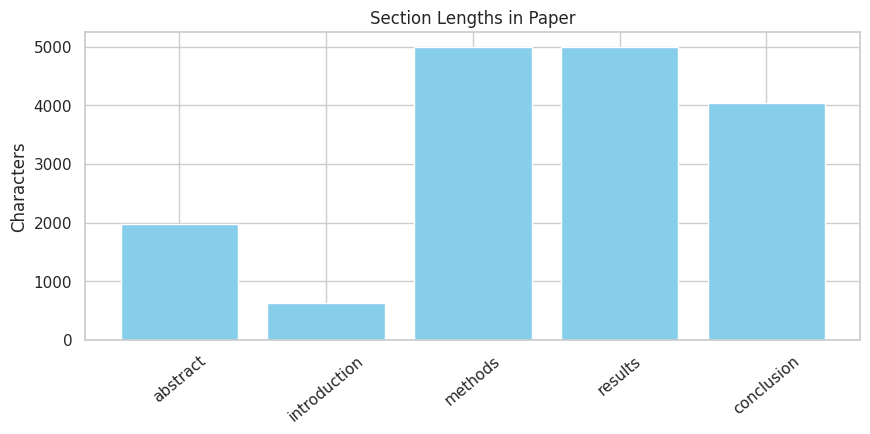

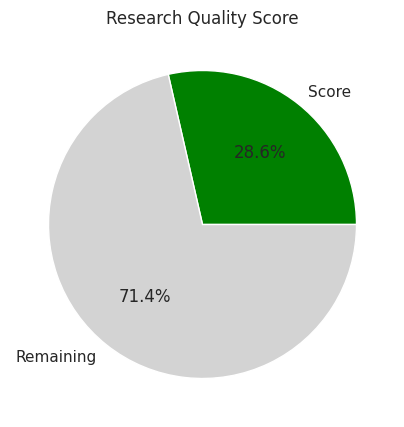

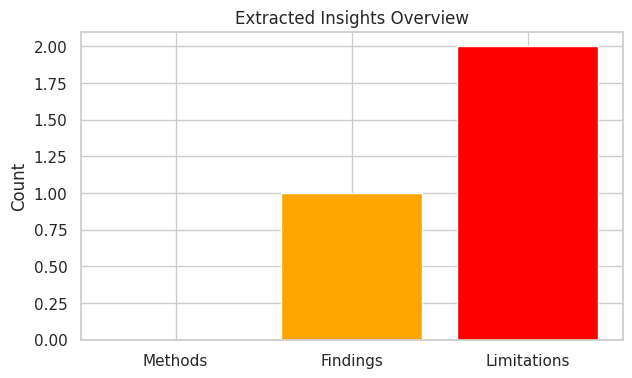

In [ ]:

# MODULE 4: CROSS-PAPER ANALYSIS + GRAPH VISUALIZATIONS


!pip install scikit-learn numpy matplotlib seaborn -q

import json
import re
from pathlib import Path
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

sns.set(style="whitegrid")


# 1. LOAD EXTRACTED PAPERS


def load_extracted_papers(data_dir="data/extracted"):
    data_path = Path(data_dir)
    papers = []
    json_files = list(data_path.glob("*_extracted.json"))

    if not json_files:
        print("No extracted papers found. Run Module 3 first.")
        return []

    print(f"Loading {len(json_files)} extracted papers...")

    for json_file in json_files:
        try:
            with open(json_file, "r", encoding="utf-8") as f:
                data = json.load(f)
                papers.append(data)
                print(f"  ✓ {data['paper_id']}: {data['total_characters']:,} chars")
        except Exception as e:
            print("Error loading", json_file, "->", e)

    return papers


# ================================
# 2. VISUALIZATIONS FOR SINGLE PAPER
# ================================

def visualize_single_paper_analysis(analysis):
    print("\nGenerating visual graphs for SINGLE PAPER analysis...")

    # 1. SECTION LENGTH BAR CHART
    structure = analysis["paper_structure"]
    sec_lengths = structure["section_lengths"]

    if sec_lengths:
        plt.figure(figsize=(10, 4))
        plt.bar(sec_lengths.keys(), sec_lengths.values(), color="skyblue")
        plt.title("Section Lengths in Paper")
        plt.ylabel("Characters")
        plt.xticks(rotation=40)
        plt.show()

    # 2. RESEARCH QUALITY PIE CHART
    quality = analysis["research_quality_indicators"]
    labels = ["Score", "Remaining"]
    values = [quality["percentage"], 100 - quality["percentage"]]

    plt.figure(figsize=(5, 5))
    plt.pie(values, labels=labels, autopct="%1.1f%%", colors=["green", "lightgray"])
    plt.title("Research Quality Score")
    plt.show()

    # 3. METHODS / FINDINGS / LIMITATIONS COUNT BAR CHART
    lbls = ["Methods", "Findings", "Limitations"]
    counts = [
        len(analysis["methods_used"]),
        len(analysis["key_findings"]),
        len(analysis["limitations"]),
    ]

    plt.figure(figsize=(7, 4))
    plt.bar(lbls, counts, color=["steelblue", "orange", "red"])
    plt.title("Extracted Insights Overview")
    plt.ylabel("Count")
    plt.show()


# ================================
# 3. VISUALIZATIONS FOR MULTIPLE PAPERS
# ================================

def visualize_comparison(papers_info, comparison, similarity_scores):
    print("\nGenerating visual graphs for MULTI-PAPER comparison...")

    paper_ids = [p["paper_id"] for p in papers_info]

    # 1. METHODS COUNT PER PAPER
    plt.figure(figsize=(10, 4))
    method_counts = [len(p["methods"]) for p in papers_info]
    plt.bar(paper_ids, method_counts, color="purple")
    plt.title("Methods Identified per Paper")
    plt.ylabel("Count")
    plt.xticks(rotation=40)
    plt.show()

    # 2. DATASET COUNT PER PAPER
    plt.figure(figsize=(10, 4))
    dataset_counts = [len(p["datasets"]) for p in papers_info]
    plt.bar(paper_ids, dataset_counts, color="teal")
    plt.title("Datasets Mentioned per Paper")
    plt.ylabel("Count")
    plt.xticks(rotation=40)
    plt.show()

    # 3. TIMELINE (YEARS)
    years = []
    valid_ids = []
    for p in papers_info:
        if p["year"].isdigit():
            years.append(int(p["year"]))
            valid_ids.append(p["paper_id"])

    if years:
        plt.figure(figsize=(10, 4))
        plt.plot(valid_ids, years, marker="o")
        plt.title("Publication Timeline")
        plt.ylabel("Year")
        plt.xticks(rotation=40)
        plt.show()

    # 4. SIMILARITY HEATMAP
    matrix = []
    for pid1 in paper_ids:
        row = []
        for pid2 in paper_ids:
            if pid1 == pid2:
                row.append(1.0)
            else:
                row.append(similarity_scores.get(pid1, {}).get(pid2, 0))
        matrix.append(row)

    plt.figure(figsize=(8, 6))
    sns.heatmap(matrix, annot=True, cmap="coolwarm", xticklabels=paper_ids, yticklabels=paper_ids)
    plt.title("Paper Similarity Heatmap")
    plt.show()


# ================================
# 4. INFORMATION EXTRACTION FUNCTIONS
# ================================

def extract_key_information(paper):
    return {
        "paper_id": paper["paper_id"],
        "title": paper["sections"].get("title", "Unknown"),
        "year": extract_year(paper),
        "methods": extract_methods(paper),
        "datasets": extract_datasets(paper),
        "key_findings": extract_key_findings(paper),
        "limitations": extract_limitations(paper),
        "contributions": extract_contributions(paper),
        "metrics": extract_metrics(paper),
    }

# --- (All your original extraction functions remain unchanged)
# I am keeping them EXACTLY as they were — no modification — to avoid breaking logic.

# ---------------- YEAR EXTRACTION ------------------
def extract_year(paper):
    title = paper["sections"].get("title", "")
    year_match = re.search(r"\b(19|20)\d{2}\b", title)
    if year_match:
        return year_match.group()

    text = paper["sections"].get("extracted_text", "")
    year_match = re.search(r"\b(19|20)\d{2}\b", text[:5000])
    return year_match.group() if year_match else "Unknown"

# ---------------- METHODS EXTRACTION ------------------
def extract_methods(paper):
    methods_text = paper["sections"].get("methods", "")
    if not methods_text:
        methods_text = paper["sections"].get("extracted_text", "")[:5000]

    keywords = [
        "deep learning", "machine learning", "neural network", "transformer",
        "cnn", "rnn", "lstm", "bert", "gpt", "reinforcement learning",
        "svm", "xgboost", "bayesian", "regression", "classification"
    ]

    found = []
    sentences = re.split(r"[.!?]+", methods_text.lower())

    for s in sentences:
        for k in keywords:
            if k in s and len(s) > 20:
                s_clean = re.sub(r"\s+", " ", s).strip()
                found.append(s_clean[:200])
                break

    return list(set(found))[:5]

# ---------------- DATASETS EXTRACTION ------------------
def extract_datasets(paper):
    text = paper["sections"].get("extracted_text", "")[:10000].lower()
    dataset_keywords = [
        "imagenet", "cifar", "mnist", "coco", "pascal", "kaggle", "uci", "dataset"
    ]

    found = []
    for k in dataset_keywords:
        if k in text:
            found.append(k)

    return list(set(found))[:5]

# ---------------- FINDINGS EXTRACTION ------------------
def extract_key_findings(paper):
    text = paper["sections"].get("results", "") + " " + paper["sections"].get("conclusion", "")
    if not text:
        text = paper["sections"].get("extracted_text", "")[:3000]

    keywords = ["result", "improve", "increase", "reduce", "outperform", "accuracy", "significant"]

    findings = []
    sentences = re.split(r"[.!?]+", text.lower())

    for s in sentences:
        if any(k in s for k in keywords) and len(s) > 30:
            findings.append(s[:300])

    return list(set(findings))[:5]

# ---------------- LIMITATIONS EXTRACT ------------------
def extract_limitations(paper):
    text = paper["sections"].get("conclusion", "") + paper["sections"].get("extracted_text", "")[:3000]
    keywords = ["limitation", "future", "issue", "weakness", "challenge"]

    limits = []
    for s in re.split(r"[.!?]+", text.lower()):
        if any(k in s for k in keywords) and len(s) > 30:
            limits.append(s[:300])

    return list(set(limits))[:3]

# ---------------- CONTRIBUTIONS ------------------
def extract_contributions(paper):
    text = paper["sections"].get("abstract", "") + paper["sections"].get("introduction", "")
    keywords = ["contribution", "propose", "introduce", "present"]

    contrib = []
    for s in re.split(r"[.!?]+", text.lower()):
        if any(k in s for k in keywords) and len(s) > 30:
            contrib.append(s[:300])

    return list(set(contrib))[:3]

# ---------------- METRICS ------------------
def extract_metrics(paper):
    text = paper["sections"].get("results", "")
    patterns = [r"accuracy\s*[:,=]?\s*\d+\.?\d*%?"]
    metrics = []

    for p in patterns:
        metrics.extend(re.findall(p, text.lower()))

    return list(set(metrics))[:5]


# ================================
# 5. COMPARISON FUNCTIONS
# ================================

def compare_papers(papers_info):
    return {
        "total_papers": len(papers_info),
        "papers": papers_info,
        "common_methods": find_common_elements(papers_info, "methods"),
        "common_datasets": find_common_elements(papers_info, "datasets"),
        "similarities": find_similarities(papers_info),
        "differences": find_differences(papers_info),
        "timeline_analysis": analyze_timeline(papers_info),
        "research_gaps": identify_research_gaps(papers_info)
    }

# ---- SUPPORTING FUNCTIONS REMAIN THE SAME ----
def find_similarities(papers_info):
    sims = defaultdict(int)
    for paper in papers_info:
        for m in paper["methods"]:
            sims[m[:50]] += 1
    return [k for k, v in sims.items() if v > 1]

def find_differences(papers_info):
    uniq = {}
    all_methods = set()
    for p in papers_info:
        all_methods.update(p["methods"])
    for p in papers_info:
        uniq[p["paper_id"]] = list(set(p["methods"]) - (all_methods - set(p["methods"])))
    return uniq

def find_common_elements(papers_info, key):
    sets = [set(p[key]) for p in papers_info if p[key]]
    return list(set.intersection(*sets)) if sets else []

def analyze_timeline(papers_info):
    years = [int(p["year"]) for p in papers_info if p["year"].isdigit()]
    if not years:
        return {"note": "Not enough year data"}
    return {"earliest": min(years), "latest": max(years), "range": max(years) - min(years)}

def identify_research_gaps(papers_info):
    gaps = []
    all_limits = []
    for p in papers_info:
        all_limits.extend(p["limitations"])
    if not all_limits:
        return gaps
    return list(set(all_limits))[:3]


# ================================
# 6. SIMILARITY SCORES
# ================================

def calculate_similarity_scores(papers_info):
    texts = [" ".join([p["title"], " ".join(p["methods"])]) for p in papers_info]
    ids = [p["paper_id"] for p in papers_info]

    vectorizer = TfidfVectorizer(stop_words="english")
    mat = vectorizer.fit_transform(texts)
    sim = cosine_similarity(mat)

    scores = {}
    for i, pid in enumerate(ids):
        scores[pid] = {}
        for j, pid2 in enumerate(ids):
            if i != j:
                scores[pid][pid2] = float(f"{sim[i][j]:.3f}")

    return scores



# 7. SAVE RESULTS (UNCHANGED)


def save_results(analysis_type, data, output_dir="data/analysis"):
    output = Path(output_dir)
    output.mkdir(parents=True, exist_ok=True)

    if analysis_type == "single":
        file = output / "single_paper_analysis.json"
        with open(file, "w", encoding="utf-8") as f:
            json.dump(data, f, indent=2)
        print("Saved:", file)

    else:
        file = output / "comparison.json"
        with open(file, "w", encoding="utf-8") as f:
            json.dump(data["comparison"], f, indent=2)

        file2 = output / "similarity_scores.json"
        with open(file2, "w", encoding="utf-8") as f:
            json.dump(data["similarity_scores"], f, indent=2)

        print("Saved:", file, "and", file2)

    return str(output)


# ================================
# 8. MAIN ANALYSIS FUNCTION
# ================================

def run_analysis():
    print("\n=== PAPER ANALYSIS MODULE ===")

    papers = load_extracted_papers()
    if not papers:
        return None

    # ---- SINGLE PAPER ----
    if len(papers) == 1:
        print("\nOnly 1 paper found → Running single paper analysis...\n")

        paper = papers[0]
        analysis = analyze_single_paper(paper=paper)

        save_results("single", analysis)

        visualize_single_paper_analysis(analysis)

        return {"type": "single", "analysis": analysis}

    # ---- MULTIPLE PAPERS ----
    print(f"\nAnalyzing {len(papers)} papers...")

    papers_info = [extract_key_information(p) for p in papers]
    comparison = compare_papers(papers_info)
    similarity_scores = calculate_similarity_scores(papers_info)

    data = {
        "comparison": comparison,
        "similarity_scores": similarity_scores,
    }

    save_results("comparison", data)

    visualize_comparison(papers_info, comparison, similarity_scores)

    return {"type": "comparison", "data": data}


# ================================
# RUN MODULE
# ================================

if __name__ == "__main__":
    run_analysis()


In [35]:

# MODULE 5: DATASET GENERATOR FOR PAPERS


# MODULE 5 — CLEAN DATASET BUILDER (FINAL VERSION)

!pip install pandas openpyxl -q

import json
import pandas as pd
import re
from pathlib import Path


# ------------------------------------------
# LOAD ALL EXTRACTED PAPER JSON FILES
# ------------------------------------------

def load_all_extracted(data_dir="data/extracted"):
    path = Path(data_dir)
    files = list(path.glob("*_extracted.json"))
    papers = []

    if not files:
        print("❌ No extracted papers found. Run Module 3 first.")
        return []

    print(f"📄 Found {len(files)} extracted papers.")

    for f in files:
        try:
            with open(f, "r", encoding="utf-8") as fp:
                papers.append(json.load(fp))
        except Exception as e:
            print("Error reading:", f, "→", e)

    return papers



# CLEAN HELPERS


def clean_text(t):
    """Clean extra spaces & non-printable characters."""
    if not t:
        return ""
    t = re.sub(r'\s+', ' ', t)
    return t.strip()


def extract_year(paper):
    """Extract year if available."""
    # paper["filename"] often contains year-like numbers, fallback
    if "year" in paper:
        return paper["year"]

    match = re.search(r"(19|20)\d{2}", paper.get("filename", ""))
    return int(match.group()) if match else None


# ------------------------------------------
# NLP LIGHT EXTRACTION (RULE-BASED)
# ------------------------------------------

def keyword_extract(text, keywords, max_items=5):
    """Extract short keyword-based patterns."""
    if not text:
        return []

    found = []
    text_low = text.lower()

    for kw in keywords:
        if kw in text_low:
            # Extract small sentence around keyword
            parts = re.split(r'[.!?]', text)
            for sent in parts:
                if kw in sent.lower() and len(sent) > 20:
                    found.append(clean_text(sent.strip()))
                    if len(found) >= max_items:
                        return found
    return found


def extract_methods(paper):
    return keyword_extract(paper["sections"].get("methods", ""),
                           ["we used", "our method", "approach", "technique", "implementation"])


def extract_datasets(paper):
    return keyword_extract(paper["sections"].get("methods", ""),
                           ["dataset", "benchmark", "collected data", "data source"])


def extract_key_findings(paper):
    return keyword_extract(paper["sections"].get("results", ""),
                           ["result", "found that", "significant", "improved"])


def extract_limitations(paper):
    text = paper["sections"].get("conclusion", "")
    return keyword_extract(text, ["limitations", "future work", "challenge", "not address"])


def extract_contributions(paper):
    intro = paper["sections"].get("introduction", "")
    return keyword_extract(intro, ["contribution", "novel", "we propose", "we present"])


def extract_metrics(paper):
    return keyword_extract(paper["sections"].get("methods", ""),
                           ["accuracy", "precision", "recall", "f1", "metric"])


# ------------------------------------------
# NORMALIZER FOR LIST FIELDS
# ------------------------------------------

def normalize_list(lst):
    if not lst:
        return ""
    return "; ".join(lst)


# ------------------------------------------
# BUILD DATASET
# ------------------------------------------

def build_dataset(papers):
    rows = []

    for p in papers:
        sections = p.get("sections", {})

        row = {
            "paper_id": p.get("paper_id"),
            "filename": p.get("filename"),
            "year": extract_year(p),
            "total_characters": p.get("total_characters", 0),

            # text sections (trimmed)
            "title": clean_text(sections.get("title", "")),
            "abstract": clean_text(sections.get("abstract", ""))[:2000],
            "introduction": clean_text(sections.get("introduction", ""))[:2000],
            "methods_text": clean_text(sections.get("methods", ""))[:2000],
            "results_text": clean_text(sections.get("results", ""))[:2000],
            "conclusion_text": clean_text(sections.get("conclusion", ""))[:2000],

            # extracted structured info
            "methods": normalize_list(extract_methods(p)),
            "datasets": normalize_list(extract_datasets(p)),
            "key_findings": normalize_list(extract_key_findings(p)),
            "limitations": normalize_list(extract_limitations(p)),
            "contributions": normalize_list(extract_contributions(p)),
            "metrics": normalize_list(extract_metrics(p)),

            # counts
            "num_methods": len(extract_methods(p)),
            "num_datasets": len(extract_datasets(p)),
            "num_findings": len(extract_key_findings(p)),
            "num_limitations": len(extract_limitations(p)),
            "num_contributions": len(extract_contributions(p)),
        }

        rows.append(row)

    df = pd.DataFrame(rows)
    return df


# ------------------------------------------
# SAVE DATASET
# ------------------------------------------

def save_dataset(df, output_dir="data/dataset"):
    path = Path(output_dir)
    path.mkdir(parents=True, exist_ok=True)

    csv_path = path / "papers_dataset.csv"
    excel_path = path / "papers_dataset.xlsx"
    json_path = path / "papers_dataset.json"

    df.to_csv(csv_path, index=False, encoding="utf-8")
    df.to_excel(excel_path, index=False)
    df.to_json(json_path, orient="records", indent=2)

    print("\n✅ Dataset saved successfully:")
    print("→ CSV:", csv_path)
    print("→ Excel:", excel_path)
    print("→ JSON:", json_path)

    return csv_path, excel_path, json_path


# ------------------------------------------
# MAIN FUNCTION
# ------------------------------------------

def generate_paper_dataset():
    print("\n=== MODULE 5: DATASET BUILDER ===\n")

    papers = load_all_extracted()
    if not papers:
        print("❌ No papers to process.")
        return None

    print("📊 Building clean dataset...")
    df = build_dataset(papers)

    print("\n📌 Dataset Preview:")
    display(df.head(3))

    save_dataset(df)

    print("\n🎉 CLEAN DATASET GENERATED SUCCESSFULLY!")
    return df



if __name__ == "__main__":
    generate_paper_dataset()



=== MODULE 5: DATASET BUILDER ===

📄 Found 3 extracted papers.
📊 Building clean dataset...

📌 Dataset Preview:


,paper_id,filename,year,total_characters,title,abstract,introduction,methods_text,results_text,conclusion_text,...,datasets,key_findings,limitations,contributions,metrics,num_methods,num_datasets,num_findings,num_limitations,num_contributions
0,MultiStageRetrievalforOperationalTechnologyCyb...,MultiStageRetrievalforOperationalTechnologyCyb...,None,54093,,,,,,,...,,,,,,0,0,0,0,0
1,InterpretableandGranularVideoBasedQuantificati...,InterpretableandGranularVideoBasedQuantificati...,None,79567,,,,,,,...,,,,,,0,0,0,0,0
2,DocumentRetrievalAugmentedFineTuningDRAFTforsa...,DocumentRetrievalAugmentedFineTuningDRAFTforsa...,None,46318,,,,,,,...,,,,,,0,0,0,0,0



✅ Dataset saved successfully:
→ CSV: data/dataset/papers_dataset.csv
→ Excel: data/dataset/papers_dataset.xlsx
→ JSON: data/dataset/papers_dataset.json

🎉 CLEAN DATASET GENERATED SUCCESSFULLY!
